# Imports

- select the voice_isolate_env kernel from top right of screen

In [ ]:
from data import CleanDataset, DataTransformer, NoiseGenerator
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from pathlib import Path
from autoencoder import UNet, autoencoder_loss, UNet_double
from evaluate_contr import evaluate_contrastive
# from vae import CustomVAE, vae_loss, AttnParams

output_folder = Path('../playground_outputs')
output_folder.mkdir(exist_ok=True)
model_path = Path('/Users/bennygrey/Desktop/mit/6.7960/Voice_Isolation/other_models/new_contrastive_model_with_decoder.pth')
device = 'mps'

# Download Dataset

In [14]:
dataset = CleanDataset(chunk_size = 50_000, split = 'train-clean-100', count = 2000)
sigma_noise = 0.1
env_scale = 3

dt = DataTransformer()
ng = NoiseGenerator()
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

Noise Categories ['NRIVER', 'PRESTO', 'NPARK', 'SCAFE', 'OMEETING', 'NFIELD', 'OOFFICE', 'PCAFETER', 'DWASHING', 'TMETRO', 'TCAR', 'DLIVING', 'PSTATION', 'STRAFFIC', 'SPSQUARE', 'DKITCHEN', 'TBUS', 'OHALLWAY']


# Test Contrastive Model Separates negatives and groups positives

In [15]:
waveform, sample_rate = next(iter(dataloader))
print(waveform.shape)
dt.waveform_to_audio(waveform, sample_rate, fname = output_folder / 'original')

amp_clean, phase_clean, _ = dt.waveform_to_spectrogram(waveform)
_, W,H = amp_clean.shape


# noisy_waveform = ng.add_environment(waveform, category_num=10, scale=env_scale)
noisy_waveform = ng.add_gaussian(waveform, sigma=sigma_noise)
amp_noisy, phase_noisy, minmax_info = dt.waveform_to_spectrogram(noisy_waveform)
dt.waveform_to_audio(noisy_waveform, sample_rate, output_folder / 'noisy')


torch.Size([16, 50000])


In [16]:
# attn_params = AttnParams(num_heads=4, window_size=None, use_rel_pos_bias=False, dim_head=64)
# model = CustomVAE(in_channels=1, spatial_dims=2, use_attn=False, vae_latent_channels=16,
#                     attn_params=attn_params, vae_use_log_var = True, beta = beta, dropout_prob=0, blocks_down=(1,2,2,4),
#                     blocks_up = [1,1,1])
model = UNet_double(input_channels = 1, final_activation='tanh')
state = torch.load(model_path, map_location=device)
encoder = model.encoder_contrastive
model.load_state_dict(state)
model.to(device)

UNet_double(
  (encoder_contrastive): Encoder(
    (conv1): ConvBlock(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): ConvBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): ConvBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (pool3): MaxPool2d(kerne

tensor([-0.0006, -0.0006, -0.0006,  ...,  0.0421,  0.0423,  0.0425],
       device='mps:0', grad_fn=<Unique2Backward0>)
torch.Size([16, 65536]) torch.Size([16, 65536])
Dot products of positive pairs: tensor([0.9320, 0.9364, 0.9680, 0.9557, 0.9696, 0.9563, 0.9398, 0.9496, 0.9394,
        0.9556, 0.9465, 0.9399, 0.9565, 0.9656, 0.9400, 0.9411],
       device='mps:0', grad_fn=<SumBackward1>)
Dot products of negative pairs: [0.9112758040428162, 0.9118480682373047, 0.902747631072998, 0.9012292623519897, 0.9220625162124634, 0.9053874015808105, 0.8885622620582581, 0.9122598171234131, 0.907538652420044, 0.9055438041687012, 0.9112978577613831, 0.9169763326644897, 0.8849813342094421, 0.909173846244812, 0.9202011823654175, 0.9203405380249023, 0.9200875759124756, 0.916889488697052, 0.9147254228591919, 0.920393705368042, 0.916688084602356, 0.8786439299583435, 0.9311752915382385, 0.9208953380584717, 0.9114307165145874, 0.9154861569404602, 0.9223384857177734, 0.894034743309021, 0.9063335061073303, 0.

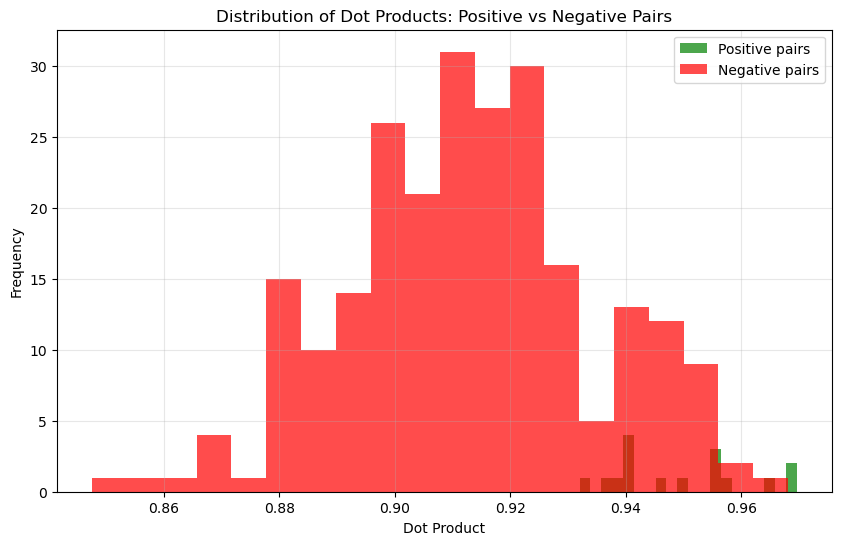

In [17]:
input_noisy = dt.add_padding(amp_noisy).unsqueeze(1).to(device)
input_clean = dt.add_padding(amp_clean).unsqueeze(1).to(device)

enc_noisy, _ = encoder(input_noisy)
enc_clean, _ = encoder(input_clean)

# normalize embeddings
enc_noisy = F.normalize(enc_noisy.flatten(start_dim=1), p=2, dim=1)
print(enc_noisy.unique())
enc_clean = F.normalize(enc_clean.flatten(start_dim=1), p=2, dim=1)
print(enc_clean.shape, enc_noisy.shape)
dot_products_positives = (enc_clean * enc_noisy).sum(dim=[1])  # [2]
print("Dot products of positive pairs:", dot_products_positives)
# Compute dot products for all negative pairs (i != j)
batch_size = enc_clean.shape[0]
neg_dot_products = []
for i in range(batch_size):
    for j in range(batch_size):
        if i != j:
            neg_dot_products.append((enc_clean[i] * enc_noisy[j]).sum().item())
print("Dot products of negative pairs:", neg_dot_products)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dot_products_positives.cpu().detach().numpy(), bins=20, alpha=0.7, label='Positive pairs', color='green')
plt.hist(neg_dot_products, bins=20, alpha=0.7, label='Negative pairs', color='red')
plt.xlabel('Dot Product')
plt.ylabel('Frequency')
plt.title('Distribution of Dot Products: Positive vs Negative Pairs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
input = dt.add_padding(amp_noisy).unsqueeze(1).to(device)

output = model(input)
amp_recon = output[:, :, :W, :H]

# Loss
target = amp_clean.to(device).unsqueeze(1)
loss = autoencoder_loss(amp_recon, target)
amp_recon = amp_recon[:, 0, :, :]

print("Loss", loss)

dt.save_spectrograms(
    amps =   [amp_clean.detach(), amp_noisy.detach(), amp_recon.detach(), ],
    phases = [phase_clean.detach(), phase_noisy.detach(), phase_noisy.detach()],
    names = ['original', 'noisy', 'recon'], 
    out_dir = output_folder / 'spectrograms'
)
# dt.save_spectrogram(amp_clean.detach(), phase_clean.detach(), output_folder / 'input')
# dt.save_spectrogram(amp_recon.detach(), phase_noisy.detach(), output_folder / 'recon')
# dt.save_spectrogram(amp_noisy.detach(), phase_noisy.detach(), output_folder / 'noisy')
waveforms_reconstr = dt.spectrogram_to_waveform(amp_recon.cpu(), phase_noisy.cpu(), *minmax_info)
dt.waveform_to_audio(waveforms_reconstr, sample_rate = sample_rate, fname = output_folder / 'reconstr')

Loss tensor(0.2424, device='mps:0', grad_fn=<MseLossBackward0>)
